In [1]:
# 라이브러리 불러오기 및 함수화
import os
import re
import shutil
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import torch
from torch.utils.data import Dataset
from konlpy.tag import Komoran
from pykospacing import Spacing
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import ElectraTokenizer, ElectraForSequenceClassification, Trainer, TrainingArguments
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

komoran = Komoran()
spacing = Spacing()
label_encoder = LabelEncoder()

# tqdm과 pandas 통합
tqdm.pandas()

In [ ]:
# 데이터 불러오기
df = pd.read_excel(r'..\..\..\\data\bitcoin_news1.xlsx')

자연어처리 (Komoran 토큰화, 불용어처리)

In [ ]:
# 기본 불용어 불러오기
korean_stopwords_path = '..\..\..\data\stopwords-ko.txt'
with open(korean_stopwords_path, encoding='utf8') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]

# 텍스트 전처리 함수
def preprocessing(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = spacing(text)
    text = text.lower()
    return text

# komoran토큰화 & 불용어 처리 함수
def remove_stopwords(text, stopwords):
    tokens = []
    morphs = komoran.morphs(text)
    for token in morphs:
        if token not in stopwords:
            tokens.append(token)
    return tokens

# 텍스트 전처리 및 토큰화, 불용어 처리
cleaned_data = []

for i in tqdm(range(len(df)), desc="Processing"):
    feature_text = df.loc[i, 'summary_content']
    processed_text = preprocessing(feature_text)
    cleaned_text = remove_stopwords(processed_text, stopwords)
    cleaned_data.append(cleaned_text)

df['cleaned'] = cleaned_data

# 라벨 인코딩
df['Outcome'] = label_encoder.fit_transform(df['Outcome'])

# 데이터 불균형 처리
X = df['cleaned'].values.reshape(-1, 1)
y = df['Outcome']

In [90]:
# 데이터 불균형 처리
X = df['cleaned'].values.reshape(-1, 1)  # 1열의 2D 배열로 변환
y = df['Outcome']

# # RandomUnderSampler로 언더샘플링
# rus = RandomUnderSampler(random_state=42)
# X_resampled, y_resampled = rus.fit_resample(X, y)

# df_resampled = pd.DataFrame({'cleaned': X_resampled.flatten(), 'Outcome': y_resampled})

# 데이터셋 분리
train_df, eval_df = train_test_split(df, test_size=0.2, random_state=42)

train_texts = train_df['cleaned'].tolist()
train_labels = train_df['Outcome'].tolist()

eval_texts = eval_df['cleaned'].tolist()
eval_labels = eval_df['Outcome'].tolist()

In [ ]:
# PyTorch Dataset 클래스 정의
# 뉴스 기사 텍스트와 레이블을 사용하여 PyTorch의 DataLoader와 함께 사용할 수 있는 데이터셋 만듦
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_len): # 클래스가 초기화될 때 호출
        self.texts = texts # 뉴스 기사 텍스트의 리스트
        self.labels = labels # 정답 (0, 1)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts) # 데이터셋의 전체 길이 반환

    def __getitem__(self, idx):
        text = self.texts[idx]  # 리스트 인덱싱으로 수정
        label = self.labels[idx]  # 리스트 인덱싱으로 수정

        #  레이블이 문자열 형식인 경우, 정수로 변환 (레이블이 숫자 형식이어야만 모델에서 학습)
        if isinstance(label, str):
            label = int(label)  # 문자열 레이블을 정수로 변환

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)   # Convert label to an integer
        }


In [94]:
# KcELECTRA 토크나이저 로드
tokenizer = ElectraTokenizer.from_pretrained("beomi/KcELECTRA-base-v2022")

# 모델 설정 (# num_labels는 분류할 클래스의 수를 지정합니다.)
model = ElectraForSequenceClassification.from_pretrained("beomi/KcELECTRA-base-v2022", num_labels=2)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'ElectraTokenizer'.
C:\ProgramData\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream

In [96]:
# 평가지표를 계산하는 함수 정의

def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # logits이 numpy.ndarry인 경우 PyTorch 텐서로 변환
    if isinstance(logits, np.ndarray):
        logits = torch.tensor(logits)
      
    predictions = torch.argmax(logits, dim=1)
    acc = accuracy_score(labels, predictions.numpy())
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions.numpy(), average='weighted')
    return {
        'accuracy'  : acc,
        'f1'        : f1,
        'precision' : precision,
        'recall'    : recall
    }

In [98]:
# 전처리된 텍스트와 라벨로 학습 및 평가 데이터셋 인스턴스 생성
train_dataset = NewsDataset(train_texts, train_labels, tokenizer, 512)
eval_dataset = NewsDataset(eval_texts, eval_labels, tokenizer, 512)

In [100]:
# 짧은 경로 설정 (예: C:/logs)
logging_dir = os.path.abspath('C:/logs')

if os.path.exists(logging_dir):
    shutil.rmtree(logging_dir)

os.makedirs(logging_dir)

PermissionError: [WinError 32] 다른 프로세스가 파일을 사용 중이기 때문에 프로세스가 액세스 할 수 없습니다: 'C:\\logs\\INNORIX\\f7c7ed1b-7f8e-42e6-ab39-4c04fb61bd1d\\2024-08-27_INNORIX_MFTTRANSFER.LOG'

In [ ]:
# Hyperparameter grid
param_grid = {
    'num_train_epochs': [2, 3],  # 에포크 수 (모델이 전체 데이터셋을 몇 번 반복해서 학습할지)
    'per_device_train_batch_size': [16, 32],  # 학습 시 GPU 또는 CPU 한 개당 배치 크기 (훈련 배치 크기)
    'per_device_eval_batch_size': [16, 32],  # 평가 시 GPU 또는 CPU 한 개당 배치 크기 (평가 배치 크기)
    'warmup_steps': [0, 500],  # 워밍업 스텝 수 (학습 초기에 학습률을 천천히 증가시키기 위한 스텝 수)
    'weight_decay': [0.01, 0.001],  # 가중치 감쇠 비율 (AdamW 옵티마이저의 정규화 비율)
}

# 모든 조합 생성
param_combinations = list(itertools.product(*(param_grid[param] for param in param_grid)))
# itertools.product를 사용해 모든 파라미터 조합을 생성하여 리스트로 저장

best_accuracy = 0  # 최상의 정확도를 기록하기 위한 변수 초기화
best_params = None  # 최상의 파라미터 조합을 기록하기 위한 변수 초기화

# 모델 평가 함수
def compute_metrics(pred):
    labels = pred.label_ids  # 실제 레이블
    preds = np.argmax(pred.predictions, axis=1)  # 예측된 레이블 (가장 높은 확률을 가진 클래스로 선택)
    acc = accuracy_score(labels, preds)  # 정확도 계산
    return {'accuracy': acc}  # 정확도를 반환하는 딕셔너리

# Grid Search
for params in tqdm(param_combinations):
    # 각 파라미터 설정
    num_train_epochs, per_device_train_batch_size, per_device_eval_batch_size, warmup_steps, weight_decay = params
    # 현재 파라미터 조합을 순차적으로 unpacking

    # TrainingArguments 설정
    training_args = TrainingArguments(
        output_dir='./results',  # 학습 결과(모델 체크포인트 등)가 저장될 디렉토리
        num_train_epochs=num_train_epochs,  # 현재 조합에서의 에포크 수
        per_device_train_batch_size=per_device_train_batch_size,  # 현재 조합에서의 훈련 배치 크기
        per_device_eval_batch_size=per_device_eval_batch_size,  # 현재 조합에서의 평가 배치 크기
        warmup_steps=warmup_steps,  # 현재 조합에서의 워밍업 스텝 수
        weight_decay=weight_decay,  # 현재 조합에서의 가중치 감쇠 비율
        logging_dir='/logs',  # 로그 파일이 저장될 디렉토리 (TensorBoard 로그를 포함)
        logging_steps=10,  # 로그를 기록할 스텝 간격 (몇 스텝마다 로그를 기록할지)
        evaluation_strategy="epoch",  # 평가 전략: 'epoch'으로 설정하면 각 에포크가 끝날 때마다 평가
        save_safetensors=False  # 안전한 직렬화 비활성화
    )

    # ElectraForSequenceClassification 모델 로드
    model = ElectraForSequenceClassification.from_pretrained("beomi/KcELECTRA-base-v2022", num_labels=2)
    # Pretrained KcELECTRA 모델을 불러오고, 2개의 클래스를 예측하도록 설정

    # Trainer 설정
    trainer = Trainer(
        model=model,  # 학습할 모델 (KcELECTRA)
        args=training_args,  # 앞에서 설정한 학습 파라미터들 (TrainingArguments)
        train_dataset=train_dataset,  # 학습에 사용될 데이터셋
        eval_dataset=test_dataset,  # 평가에 사용될 데이터셋
        compute_metrics=compute_metrics  # 평가 시 사용할 커스텀 메트릭스 (여기서는 accuracy)
    )

    # 모델 학습
    trainer.train()  # 주어진 파라미터 조합으로 모델 학습

    # 모델 평가
    eval_results = trainer.evaluate()  # 테스트 데이터셋을 사용해 모델 평가
    accuracy = eval_results['eval_accuracy']  # 평가 결과에서 정확도를 추출
    
    # 현재 파라미터 조합과 그에 따른 정확도 출력
    print(f"Params: {params}, Accuracy: {accuracy}")

    # 최적의 파라미터와 정확도 저장
    if accuracy > best_accuracy:  # 현재 정확도가 최상의 정확도보다 높으면
        best_accuracy = accuracy  # 최상의 정확도를 업데이트
        best_params = params  # 최상의 파라미터 조합을 업데이트


# 최적의 파라미터 조합과 그에 따른 정확도 출력
print(f"Best Params: {best_params}, Best Accuracy: {best_accuracy}")

In [102]:
# TrainingArguments 설정
training_args = TrainingArguments(
    output_dir='./results',              # 학습 결과(모델 체크포인트 등)가 저장될 디렉토리
    num_train_epochs=1,                  # 학습할 에포크 수 (모델이 전체 데이터셋을 몇 번 반복해서 학습할지)
    per_device_train_batch_size=16,      # 학습 시 GPU 또는 CPU 한 개당 배치 사이즈 (훈련 배치 크기)
    per_device_eval_batch_size=16,       # 평가 시 GPU 또는 CPU 한 개당 배치 사이즈 (평가 배치 크기)
    warmup_steps=500,                    # 학습 초기에 학습률을 천천히 증가시키기 위한 워밍업 스텝 수
    weight_decay=0.01,                   # AdamW 옵티마이저의 가중치 감쇠(정규화) 비율
    logging_dir='C:/logs',                # 로그 파일이 저장될 디렉토리 (TensorBoard 로그를 포함)
    logging_steps=10,                    # 로그를 기록할 스텝 간격 (몇 스텝마다 로그를 기록할지)
    evaluation_strategy="epoch",         # 평가 전략: 'epoch'으로 설정하면 각 에포크가 끝날 때마다 평가
)

# Trainer 설정
trainer = Trainer(
    model=model,                         # 학습할 모델 (여기서는 KcELECTRA 모델)
    args=training_args,                  # 앞에서 설정한 학습 파라미터들 (TrainingArguments)
    train_dataset=train_dataset,         # 학습에 사용될 데이터셋
    eval_dataset=eval_dataset,           # 평가에 사용될 데이터셋
    compute_metrics=None                 # 평가 시 사용할 커스텀 메트릭스 (None이면 기본 메트릭 사용)
)


C:\ProgramData\anaconda3\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [104]:
# Trainer가 모델을 저장할 때 safetensors 형식을 사용하지 않고, 
#  PyTorch의 .bin 파일 형식을 사용하도록 지정
trainer.args.save_safetensors = False 

In [106]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.591100,0.509128


TrainOutput(global_step=354, training_loss=0.5697495472633233, metrics={'train_runtime': 29065.6603, 'train_samples_per_second': 0.195, 'train_steps_per_second': 0.012, 'total_flos': 1489208573337600.0, 'train_loss': 0.5697495472633233, 'epoch': 1.0})

TrainOutput(global_step=354, training_loss=0.5697495472633233, metrics={'train_runtime': 29065.6603, 'train_samples_per_second': 0.195, 'train_steps_per_second': 0.012, 'total_flos': 1489208573337600.0, 'train_loss': 0.5697495472633233, 'epoch': 1.0})


In [111]:
# 모델 평가 (학습 데이터셋에 대해 평가)
train_results = trainer.evaluate(train_dataset)

# 모델 평가 (검증 데이터셋에 대해 평가)
eval_results = trainer.evaluate(eval_dataset)

In [112]:
# 검증 데이터에 대한 예측 수행
y_pred = trainer.predict(eval_dataset).predictions.argmax(-1)

In [113]:
# 평가 결과 출력
print("Accuracy:", accuracy_score(eval_labels, y_pred))
print("Confusion Matrix:\n", confusion_matrix(eval_labels, y_pred))
print("Classification Report:\n", classification_report(eval_labels, y_pred))

Accuracy: 0.634180790960452
Confusion Matrix:
 [[277 201]
 [317 621]]
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.58      0.52       478
           1       0.76      0.66      0.71       938

    accuracy                           0.63      1416
   macro avg       0.61      0.62      0.61      1416
weighted avg       0.66      0.63      0.64      1416



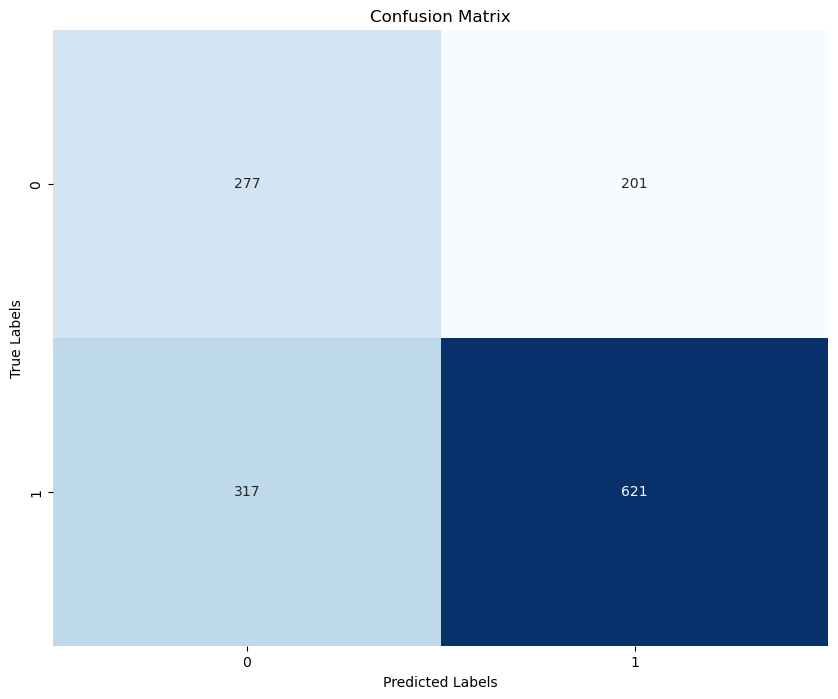

In [114]:
# 혼동행렬 계산
conf_matrix = confusion_matrix(eval_labels, y_pred)

# 혼동행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# 과대적합/과소적합 판별
train_accuracy = train_results['eval_accuracy']     # 훈련 데이터에 대한 정확도 저장
val_accuracy = eval_results['eval_accuracy']        # 검증 데이터에 대한 정확도 저장

# 훈련 정확도가 검증 정확도보다 높고, 두 정확도 간의 차이가 5% 이상일 때 과대적합 가능성 판단
if train_accuracy > val_accuracy and (train_accuracy - val_accuracy) > 0.05:
    print("The model may be overfitting.")          # 모델이 과대적합일 가능성이 있음

# 검증 정확도가 훈련 정확도보다 높을 때 과소적합 가능성 판단
elif train_accuracy < val_accuracy:
    print("The model may be underfitting.")         # 모델이 과소적합일 가능성이 있음

# 두 정확도 간의 차이가 크지 않을 때 모델이 적절하게 학습되었음을 의미
else:
    print("The model seems to have a good fit.")    # 모델이 잘 맞는 것 같음


In [129]:
# 라벨 인덱스와 실제 라벨명을 매핑한 딕셔너리
label_map = {0: '악재', 1: '호재'}

# 텍스트를 입력 받아 예측하는 함수 정의
def predict_text(text, model, tokenizer, max_len):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens   =True,
        max_length           =max_len,
        return_token_type_ids=False,
        padding              ='max_length',
        truncation           =True,
        return_attention_mask=True,
        return_tensors       ='pt',
    )
    input_ids      = encoding['input_ids']
    attention_mask = encoding['attention_mask']
    
    with torch.no_grad():
        outputs    = model(input_ids, attention_mask=attention_mask)
    
    logits     = outputs.logits
    prediction = torch.argmax(logits, dim=-1)
    
    return prediction.item()

In [131]:
# 테스트할 텍스트 입력
text_to_predict = '''파월 의장은 지난 24일 잭슨 홀 컨퍼런스에 참석해 연방준비제도이사회가 정책을 전환할 때라고 밝히면서 시장은 향후 금리 인하 체제에 대한 더 많은 신호가 나올 것으로 기대하면서 가상화폐 시장도 즉각적으로 반응했다.

현재 미국 중앙은행의 대규모 당일 콜 자금시장 대출 금리는 5.25%~5.5% 범위에 있다. 이와 관련 파월은 잭슨 홀 연설에서 금리 인하 방침을 명백히 밝히면서 "금리를 인하할 것이냐가 아니라 폭을 어느 정도로 할 것이냐의 문제"라고 말했다.

그는 "정책을 조정할 때가 왔다. 이동 방향은 명확하지만, 금리 인하의 시기와 속도는 나오는 데이터와 변화하는 전망, 그리고 위험의 균형에 따라 달라질 것"이라고 강조했다.

낮은 금리와 늘어나는 달러(유동성) 공급은 공급이 제한된 블록체인 가상화폐 가격을 끌어올릴 가능성이 매우 크다. 일부 디지털 자산은 엄격한 공급 한도로 인해 저금리 달러 환경에서는 귀중한 투자상품이 될 수 있다.'''

# 예측
predicted_label_index = predict_text(text_to_predict, model, tokenizer, 512)

# 예측 결과 출력
predicted_label = label_map[predicted_label_index]
print(f"Predicted Label: {predicted_label}")

Predicted Label: 호재


In [133]:
import torch
import h5py

# 모델의 가중치 저장
model_weights = model.state_dict()

# h5 파일로 저장
with h5py.File('News_Bitcoin_KcELECTRA_model.h5', 'w') as h5_file:
    for key, value in model_weights.items():
        h5_file.create_dataset(key, data=value.cpu().numpy())

print("Model weights have been saved as News_Bitcoin_KcELECTRA_model.h5")


Model weights have been saved as News_Bitcoin_KcELECTRA_model.h5
